# Hyperparameter optimization

### Acknowledgments & Credits

This lesson is adapted largely from the excellent curriculum materials by Cliburn Chan (2021) at https://github.com/cliburn/bios-823-2021/ under the MIT License.

### References

- [Optuna homepage](https://optuna.org/)
- [Optuna documentation](https://optuna.readthedocs.io/)

## Prepare dataset: MNIST

In [1]:
import keras

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Define the objective

The objective is to optimize the hyperparameters of a neural network. We will use the `optuna` library to orchestrate and run the optimization _trials_ as a _study_.

Optuna expects a callable object which will be passed a `trial` object.
- The `trial` object is used to sample hyperparameters and report the objective value.
- The objective value is the value of the loss function that we are trying to minimize.

The callable object could be a function or a class with a `__call__` method. We will use a class with a `__call__` method so that we can easily store and access the data and fixed parameters.

In [3]:
import optuna

In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

In [5]:
def create_model(input_shape, dropout=0.1, num_classes=10):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
from keras.ops import convert_to_tensor

In [7]:
class Objective(object):
    def __init__(self, X, y, 
                 max_epochs, 
                 input_shape, 
                 num_classes):
        self.X = convert_to_tensor(X)
        self.y = convert_to_tensor(y)
        self.max_epochs = max_epochs
        self.input_shape = input_shape
        self.num_classes = num_classes
 
    def __call__(self, trial):        
        dropout = trial.suggest_float('dropout', 0.1, 0.4, step=0.05)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 96])
        epochs = trial.suggest_int('epochs', 1, self.max_epochs, step=1)   

        model = create_model(input_shape=self.input_shape,
                             dropout=dropout,
                             num_classes=self.num_classes)
            
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])                 
             
        # fit the model
        hist = model.fit(x=self.X, y=self.y,
                          batch_size=batch_size,
                          validation_split=0.25,
                          epochs=epochs)
                 
        loss = np.min(hist.history['val_loss'])
                 
        return loss

In [8]:
optuna.logging.set_verbosity(0)

## Prepare and run study    

In [9]:
N = 6
max_epochs = 3
input_shape = (28,28,1)
num_classes = 10

In [10]:
%%time

objective = Objective(X_train, y_train, max_epochs, input_shape, num_classes)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N)

2024-11-27 17:09:34.244632: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-27 17:09:34.244650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-11-27 17:09:34.244665: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-11-27 17:09:34.244682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-27 17:09:34.244694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-27 17:09:34.936664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8795 - loss: 0.3822 - val_accuracy: 0.9827 - val_loss: 0.0580
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8765 - loss: 0.3900 - val_accuracy: 0.9817 - val_loss: 0.0575
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8742 - loss: 0.4156 - val_accuracy: 0.9813 - val_loss: 0.0603
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8644 - loss: 0.4245 - val_accuracy: 0.9828 - val_loss: 0.0606
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8856 - loss: 0.3725 - val_accuracy: 0.9813 - val_loss: 0.0634
Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8706 - loss: 0.4109 - val_accuracy: 0.9813 - val_loss: 0.0615
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9785 - loss: 0.0704 - val_accuracy: 0.9849 - val_loss: 0.0515
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9844 - loss: 0.0492 - val_accuracy: 0.9858 - val_loss: 0.0479
CPU times: use

## Inspect and visualize study results

In [15]:
df = study.trials_dataframe()

In [19]:
df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_epochs,state
0,0,0.058012,2024-11-27 17:09:34.281652,2024-11-27 17:09:54.897451,0 days 00:00:20.615799,32,0.40,1,COMPLETE
1,1,0.057474,2024-11-27 17:09:54.897565,2024-11-27 17:10:15.165447,0 days 00:00:20.267882,32,0.40,1,COMPLETE
2,2,0.060288,2024-11-27 17:10:15.165521,2024-11-27 17:10:25.131312,0 days 00:00:09.965791,96,0.20,1,COMPLETE
3,3,0.060588,2024-11-27 17:10:25.131399,2024-11-27 17:10:38.767878,0 days 00:00:13.636479,64,0.30,1,COMPLETE
4,4,0.063435,2024-11-27 17:10:38.767948,2024-11-27 17:10:48.912267,0 days 00:00:10.144319,96,0.10,1,COMPLETE
5,5,0.047923,2024-11-27 17:10:48.912338,2024-11-27 17:11:27.157779,0 days 00:00:38.245441,64,0.35,3,COMPLETE


In [20]:
from optuna.visualization.matplotlib import plot_param_importances

/var/folders/_m/95yqs0kj1xsd4l92yjkfr2hm0000gn/T/ipykernel_95964/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

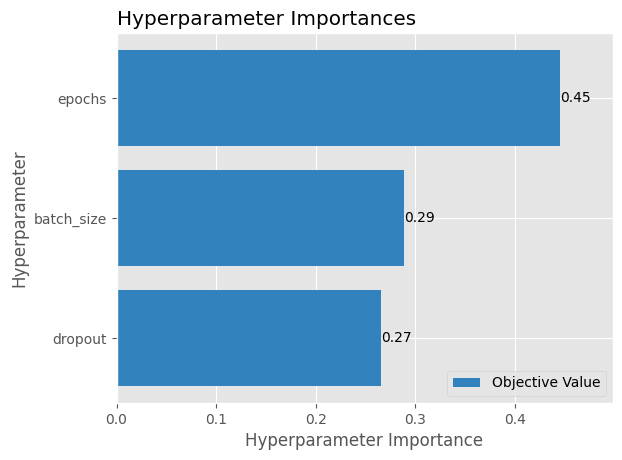

In [21]:
plot_param_importances(study)